<a href="https://colab.research.google.com/github/yashs33244/Music_similar_taste/blob/main/music_generation_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Installing dependencies
!pip install music21
!apt-get install -y lilypond

Processing triggers for tex-common (6.17) ...
Running updmap-sys. This may take some time... done.
Running mktexlsr /var/lib/texmf ... done.
Building format(s) --all.
	This may take some time... done.


In [ ]:
#Importing Libraries
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

<a id="2"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">LOADING DATA</p>

For this project, I will be using MIDI files of classical piano music. The dataset includes various artists. I will be working with Frédéric Chopin's compositions.

* First of all, I make a list of all the songs in the Chopin folder parsed as music21 stream.

* Then I will be creating a function to extract chords and notes out of the data creating a corpus.

**Laoding and parsing data**

In [ ]:
pip install librosa

In [ ]:
pip install pretty_midi

In [ ]:
!pip install crepe

  Created wheel for crepe: filename=crepe-0.0.14-py3-none-any.whl size=134848688 sha256=9188f4a36f2d419e358e234f78e0ea697a42642a33a1b5b711655e6f380cae9c
  Stored in directory: /root/.cache/pip/wheels/63/94/70/ceaf23147122e5acb47c7332002e0af8aea888cd3330e0cbfc
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320706 sha256=ff1784dea802b4427fbd2bded1a0a8f3649a57399cdc71e367354c5a4b27c0e3
  Stored in directory: /root/.cache/pip/wheels/e5/a0/79/29e61754e5b3941ad4c7d01bf5bea99768e64e4bdd3180f32b
Successfully built crepe resampy


In [ ]:


# import os
# import librosa
# import pretty_midi
# import crepe

# filepath = "D:\Torrent downloads\Samples\KSHMR VOLUME 3\KSHMR_Live_Instruments\KSHMR_Main_Instruments\KSHMR_Guitar\KSHMR_Guitar_Chords\KSHMR_Electric_Chords/"

# # Getting midi files
# all_midis= []
# for i in os.listdir(filepath):
#     if i.endswith(".wav"):
#         tr = filepath+i

#         # Load the audio file
#         audio, sample_rate = librosa.load(tr)

#         # Extract pitch information from the audio file
#         time, frequency, confidence, activation = crepe.predict(audio, sr=sample_rate, viterbi=True)

#         # Create a PrettyMIDI object
#         midi = pretty_midi.PrettyMIDI()

#         # Create an Instrument object
#         instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))

#         # Add notes to the Instrument object
#         for t, f in zip(time, frequency):
#             if f > 0:
#                 note_number = int(round(pretty_midi.hz_to_note_number(f)))
#                 note_start = t
#                 note_end = t + 0.1
#                 note = pretty_midi.Note(
#                     velocity=100, pitch=note_number, start=note_start, end=note_end)
#                 instrument.notes.append(note)

#         # Add the Instrument object to the PrettyMIDI object
#         midi.instruments.append(instrument)

#         all_midis.append(midi)
# all_midis= []
# for i in os.listdir(filepath):
#     if i.endswith(".wav"):
#         tr = filepath+i

#         # Load the audio file



#         audio, sample_rate = librosa.load(tr)

#         # Convert the audio file to MIDI

#         midi = librosa.audio2midi(audio, sample_rate)

#         all_midis.append(midi)

In [ ]:
#Loading the list midi files as stream
filepath = r"/content/drive/MyDrive/music project/MIDI"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = os.path.join(filepath, i)
        midi = converter.parse(tr)
        all_midis.append(midi)

Next, I get the components out of these streams of MIDI files. The midi files only have the piano included as mentioned in the dataset. So the components of the file would be either piano chords or piano notes.

**Note:** The musical notes are the building blocks of the music. It pertains to a pitch associated with a specific audio vibration. Western music utilizes twelve musical notes.

**Chord:** A group of notes that sound good together is a chord.

The music21 stream that was created in the above cell contains both, chords and notes, we will extract them in the form of notes and obtain a series of notes in the musical composition.

**The function to get the notes:**

In [ ]:
import music21
#Helping function
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the splice midis in the dataset:", len(Corpus))

Total notes in all the splice midis in the dataset: 3863


So we have our data in the form of a corpus. A list of strings, if you will. Each string indicates a musical note. Let us explore this data corpus.

<a id="3"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">DATA EXPLORATION</p>

**In this section, I will be:**
* Exploring the data Corpus
* Examine all the notes in the Corpus
* Simplifying our Corpus to Built a working model

**Let us have a look at the first 50 values in our corpus**

In [ ]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['4', 'G4', 'B4', '0', 'G4', 'B4', 'G4', 'B4', '9', 'G4', 'B4', 'G4', 'B4', 'C6', '9', 'G4', 'B4', 'B5', '4', 'G4', 'B4', '0', 'G4', 'B4', 'G4', 'B4', '9', 'G4', 'B4', 'G4', 'B4', 'C6', '9', 'G4', 'B4', 'B5', '2.4', 'G3', 'B3', '11.2', 'F#3', 'A3', '0.4', 'G3', 'B3', '9.0', 'E3', 'B3', '2.4', 'G3']


All these values indicate the notes, as mentioned above.

**Printing the music sheet**

In [ ]:
from music21 import *

#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))

def create_note(note_value):
    return note.Note(note_value)

def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = create_note(inst_note)
                notes.append(note_snip)
            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = create_note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

us = environment.UserSettings()
us['lilypondPath'] = '/content/drive/MyDrive/music project/MIDI' # Replace with the actual path to Lilypond on your system
environment.set('lilypondPath', '/content/drive/MyDrive/music project/MIDI') # Replace with the actual path to Lilypond on your system


**Playing the above sheet music**

*As I could not play a midi file on the Kaggle interface, I have created a ".wav" filetype of the same outside of this code. I am using it to create an audio interface. Let us have a listen to the data corpus.*

In [ ]:
#to play audio or corpus
print("Sample Audio From Data")
IPython.display.Audio("/content/drive/MyDrive/music project/MIDI/Cymatics - Oracle Classic MIDI 3 - C Min.mid")

In [ ]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 254


**Examine all the notes in the Corpus**

In [ ]:
from collections import Counter
import numpy as np

# ... (previous code for extracting notes from .wav files)

# # Convert numpy arrays to hashable types (e.g., tuples)
# hashable_corpus = [tuple(note) if isinstance(note, np.ndarray) else note for note in Corpus]

# Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

# Displaying the count of each note
for note, count in count_num.items():
    print(f"Note: {note}, Count: {count}")


In [ ]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 15.208661417322835
Most frequent note in Corpus appeared: 116 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody; some so rare that it was played only once in the whole data. This would create a lot of problems. (I did run into most of them while writing this piece)
To spare us the error reports, let us have a look at the frequency of the notes.
And for simplicity, I shall be eliminating some of the least occurring notes. I am sure Chopin wouldn't mind me messing with his masterpiece for science or would he? Either way, I may never know!   

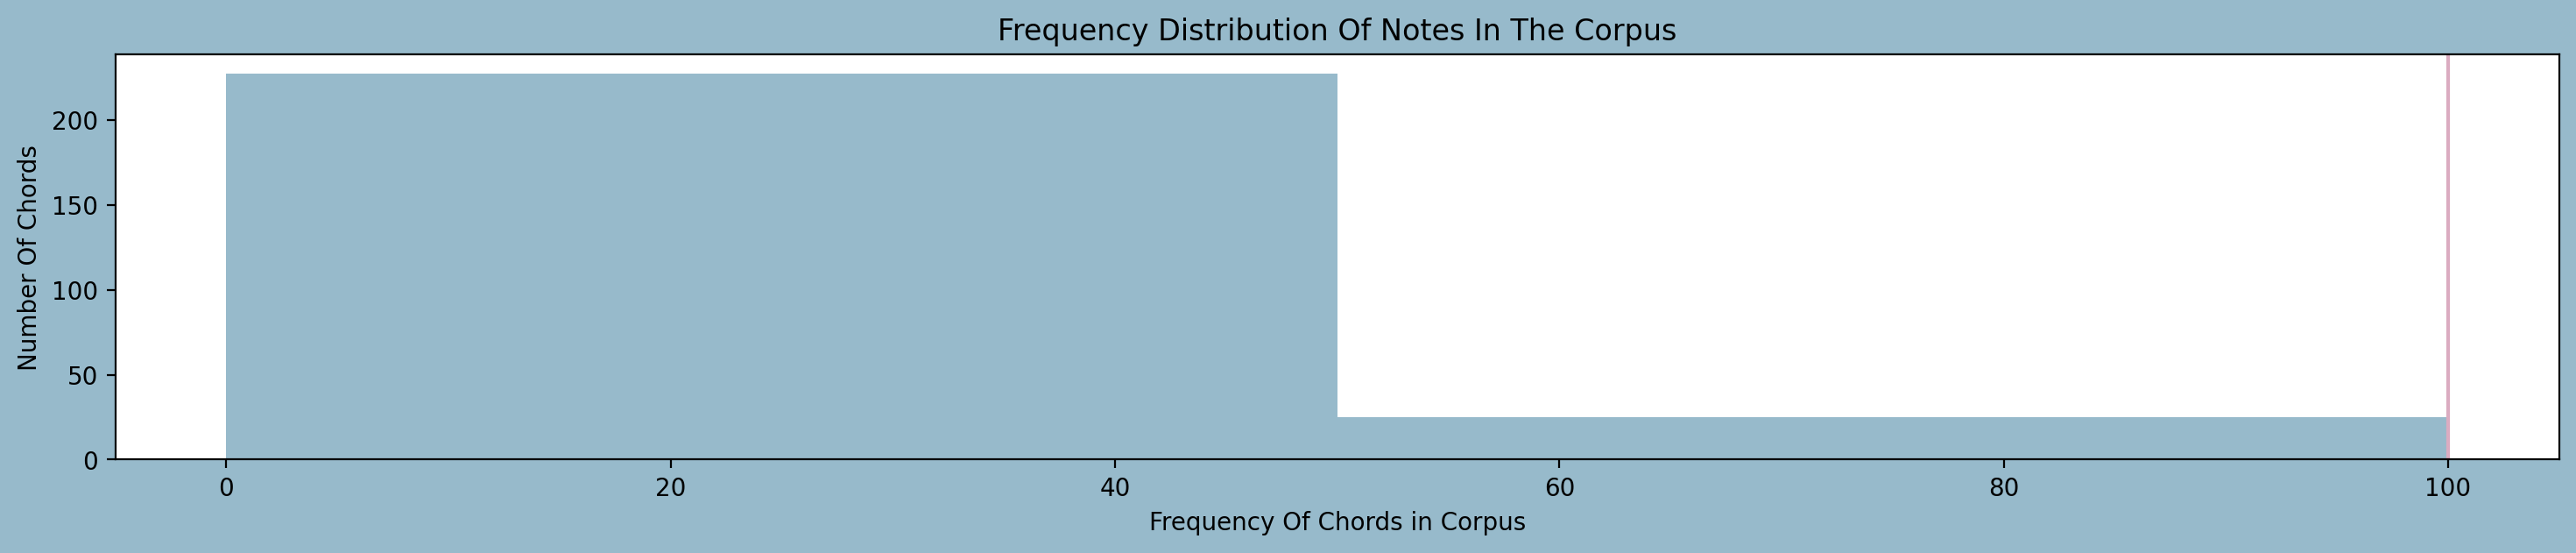

In [ ]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

I have decided, I will be taking out the notes that were played less than 100 times. I mean, if Chopin liked them he would have played it a lot more often. So I create a list of rare notes in the next section.

In [ ]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 10:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 10 times:", len(rare_note))

Total number of notes that occur less than 100 times: 158


In [ ]:
import random
import numpy as np

# Assuming rare_notes is a set or list of rare notes
common_notes = [note for note in Corpus if not np.any(np.in1d(note, rare_note))]  # Choose commonly occurring notes

# Adjust the frequency or probability of rare notes
adjusted_corpus = [
    random.choice(common_notes) if np.any(np.in1d(note, rare_note)) and random.random() > 0.2 else note
    for note in Corpus
]

print("Length of Corpus after handling rare notes:", len(adjusted_corpus))


Length of Corpus after handling rare notes: 3863


 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<new code

 -->

In [ ]:
import random
import numpy as np

# Assuming rare_notes is a set or list of rare notes
common_notes = [note for note in Corpus if not np.any(np.in1d(note, rare_note))]  # Choose commonly occurring notes

# Set the maximum allowed consecutive repetitions of a note
max_repetitions = 3

# Adjust the frequency or probability of rare notes
adjusted_corpus = []
consecutive_repetitions = 0
for note in Corpus:
    if np.any(np.in1d(note, rare_note)) and random.random() > 0.2:
        # Ensure that consecutive repetitions do not exceed the maximum
        if consecutive_repetitions < max_repetitions:
            adjusted_corpus.append(random.choice(common_notes))
            consecutive_repetitions += 1
        else:
            adjusted_corpus.append(note)
            consecutive_repetitions = 0  # Reset consecutive repetitions counter
    else:
        adjusted_corpus.append(note)
        consecutive_repetitions = 0  # Reset consecutive repetitions counter

print("Length of Corpus after handling rare notes:", len(adjusted_corpus))


Length of Corpus after handling rare notes: 3863


Finally! This is the cleaned data Corpus that I will be using for the music generation.  
In the next section, I will be preprocessing this Corpus for the training model.

The workflow for this project involves,

<p style="background-color:#EBDDD0;font-family:newtimeroman;color:#444160;text-align:center;font-size:120%;">Loading Data ➡️ Preprocessing ➡️ Building Mapping Dictionary ➡️ Building Model ➡️ Generating Music</p>

As I have loaded and explored the data,  I will proceed further by pre-processing the text.  


<a id="4"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">DATA PREPROCESSING</p>

Notes are basically sound waves. In music, we have certain specific combinations of Frequency and Wavelength standardized as said notes. Our Corpus has the name of that note. As we parsed the data at the time of loading we took the help of the music21 library (by nice people at MIT); The library fetches Frequency, Wavelength, duration etc for the given notes.



**In this section, I will be performing the following:**

**Creating a dictionary:** Creating a dictionary to map the notes and their indices. We have the note's name as a string the Corpus. For the computer, these names are just a symbol. So we create a dictionary to map each unique note in our Corpus to a number. And vice versa to retrieve the values at the time of prediction. This will be used to encode and decode the information going in and getting out of the RNN.

**Encoding and Splitting the corpus:** Encoding and splitting the corpus into smaller sequences of equal length: At this point, the Corpus contain notes. We will encode this corpus and create small sequences of equal lengths of features and the corresponding targets. Each feature and target will contain the mapped index in the dictionary of the unique characters they signify.

**Assigning X and y:** The labels are then resized and normalized. Whereas the targets are one-hot encoded. Ready to be sent to the RNN for the training, but before that let us built the RNN model.

**Splitting Train and Seed datasets** To create music we will need to send some input to the RNN. For that, we will set aside a part of the data as seeds. We could have trained it all but I am no musician to come up with an input seed value.

**Creating a list of sorted unique characters**

In [ ]:
# Storing all the unique characters present in my corpus to bult a mapping dic.
# Convert numpy arrays to hashable types (e.g., tuples)

symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 3863
Number of unique characters: 254


**Encoding and Splitting the Corpus as Labels and Targets**

In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
Corpus = [tuple(note) if isinstance(note, np.ndarray) else note for note in Corpus]
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 3823


In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

**Splitting Train and Seed datasets**

In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="5"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">MODEL BUILDING</p>

I will be employing an LSTM for this project.

**Following steps are involved in the model building**

* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model

**Building the Model**

In [ ]:
# #Initialising the Model
# model = Sequential()
# #Adding layers
# model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(256))
# model.add(Dense(256))
# model.add(Dropout(0.1))
# model.add(Dense(y.shape[1], activation='softmax'))
# #Compiling the model for training
# opt = Adamax(learning_rate=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=opt)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping

# Assuming X and y are your input and target data

# Initialising the Model
model = Sequential()

# Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))  # Increased dropout for better regularization
model.add(BatchNormalization())  # Added Batch Normalization for stability
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))  # Increased dropout for better regularization
model.add(BatchNormalization())  # Added Batch Normalization for stability
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))  # Increased dropout for better regularization
model.add(BatchNormalization())  # Added Batch Normalization for stability
model.add(LSTM(64))
model.add(Dense(256, activation='relu'))  # Adding activation function
model.add(Dropout(0.3))  # Increased dropout for better regularization
model.add(Dense(y.shape[1], activation='softmax'))

# Compiling the model for training
opt = Adamax(learning_rate=0.001)  # Adjusted learning rate
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])  # Added accuracy metric

# Adding EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
#Model's Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout_4 (Dropout)         (None, 40, 512)           0         
                                                                 
 batch_normalization_3 (Bat  (None, 40, 512)           2048      
 chNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 40, 256)           787456    
                                                                 
 dropout_5 (Dropout)         (None, 40, 256)           0         
                                                                 
 batch_normalization_4 (Bat  (None, 40, 256)           1024      
 chNormalization)                                     

In [ ]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=500)

Epoch 1/500
12/12 [==============================] - 1s 65ms/step - loss: 3.7107 - accuracy: 0.1298
Epoch 2/500
12/12 [==============================] - 1s 59ms/step - loss: 3.6883 - accuracy: 0.1331
Epoch 3/500
12/12 [==============================] - 1s 60ms/step - loss: 3.6794 - accuracy: 0.1256
Epoch 4/500
12/12 [==============================] - 1s 60ms/step - loss: 3.6825 - accuracy: 0.1409
Epoch 5/500
12/12 [==============================] - 1s 61ms/step - loss: 3.6430 - accuracy: 0.1396
Epoch 6/500
12/12 [==============================] - 1s 60ms/step - loss: 3.6324 - accuracy: 0.1295
Epoch 7/500
12/12 [==============================] - 1s 58ms/step - loss: 3.6375 - accuracy: 0.1400
Epoch 8/500
12/12 [==============================] - 1s 58ms/step - loss: 3.6064 - accuracy: 0.1367
Epoch 9/500
12/12 [==============================] - 1s 58ms/step - loss: 3.5969 - accuracy: 0.1442
Epoch 10/500
12/12 [==============================] - 1s 57ms/step - loss: 3.5873 - accuracy: 0.1308

<a id="6"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">EVALUATING MODELS</p>

Now that I have my model trained on the MIDI files of piano music, let us see how it performs.

**To evaluate my model, I shall be having a look at:**
* The performance of the model via Learning Curves
* The melody created

**Plotting the learning curve for the loss function**

In [ ]:
model.save('music_model.h5')

[Text(0.5, 0, 'Epochs')]

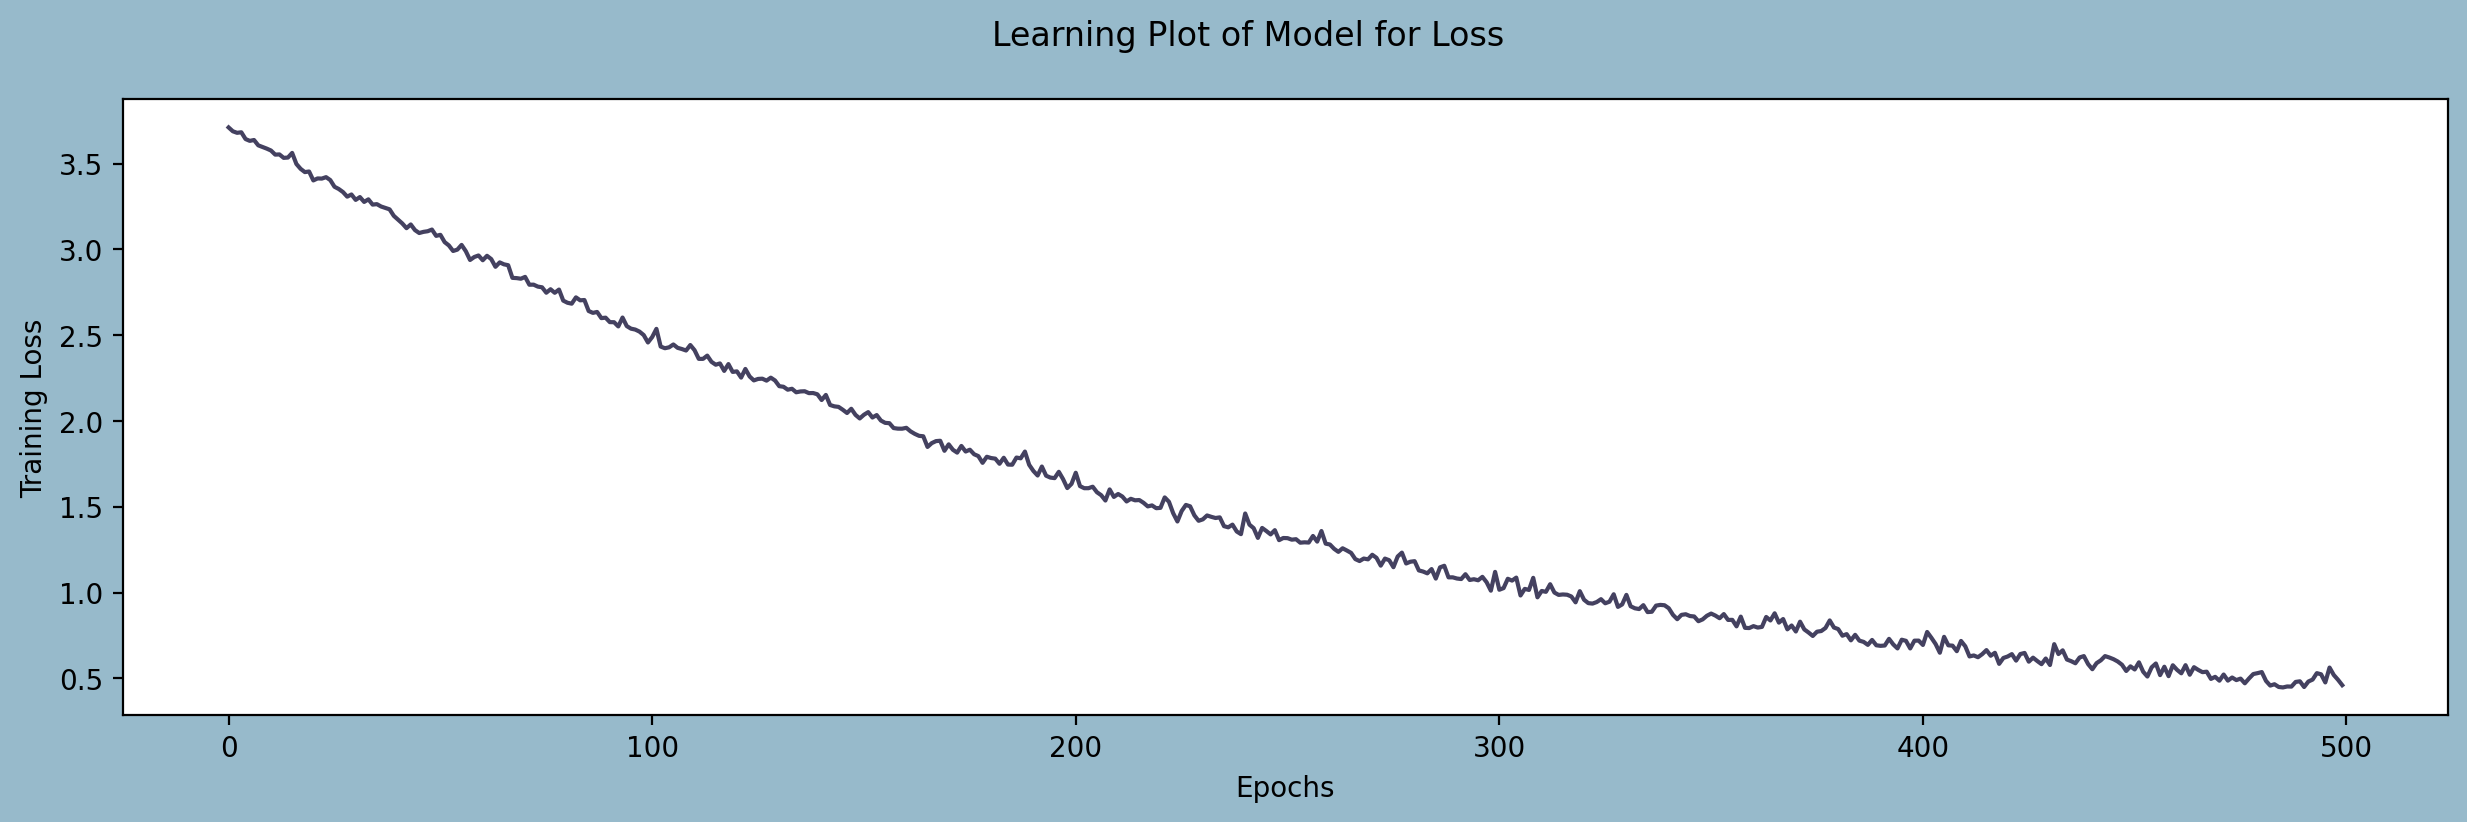

In [ ]:
#Plotting the learnings
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

**Generating the Melody**

A function to obtain the generated music

In [ ]:
def chords_n_notes(Snippet):
    Melody = music21.stream.Part()

    for i in Snippet:
        # If it is chord
        if isinstance(i, tuple) or any(char.isdigit() for char in i):
            chord_notes = i if isinstance(i, tuple) else i.split(".")  # Separating the notes in chord
            notes = []

            for note_str in chord_notes:
                if note_str.isdigit():
                    notes.append(int(note_str))
                else:
                    notes.append(note_str)

            chord = music21.chord.Chord(notes)
            Melody.append(chord)
        else:
            note = music21.note.Note(i)
            Melody.append(note)

    return Melody


In [ ]:
# Sample from the softmax output with temperature
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [ ]:
def generate_sequence(model, seed_sequence, length, temperature=1.0):
    generated_sequence = seed_sequence.copy()

    for _ in range(length):
        preds = model.predict(np.expand_dims(generated_sequence, axis=0))
        next_index = sample(preds[0, -1], temperature)
        generated_sequence.append(next_index)

    return generated_sequence


In [ ]:
import tensorflow as tf
def Malody_Generator(Note_Count,model):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = music21.stream.Stream(Melody)
    return Music,Melody_midi

loaded_model = tf.keras.models.load_model('/content/music_model.h5')
#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100,loaded_model)


This sure looks like music! To check if it sounds like music we have to listen to the MIDI file. Playing midi is crumblesome. I have saved and converted a few generated melodies to ".wav" format outside of this notebook. So let us have a listen.

**Melody Generated Sample 1**

In [ ]:
#To save the generated melody
Melody.write('midi','new_music__.mid')
#to play audio or corpus
IPython.display.Audio("/content/new_music__.mid")